In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

In [3]:
plot_themes()

In [4]:
x_train,y_train,x_valid,y_valid = get_data(mnist_path)

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
%time run.fit(2, learn)

train: [0.015969207763671875, tensor(0.9952, device='cuda:0')]
valid: [0.0643121826171875, tensor(0.9831, device='cuda:0')]
train: [0.0128285888671875, tensor(0.9959, device='cuda:0')]
valid: [0.06853532104492188, tensor(0.9835, device='cuda:0')]
Wall time: 6.61 s


## Custom Batchnorm

In [10]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [11]:
xb, yb=next(iter(data.train_dl))

In [12]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [13]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [14]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.2565270703125, tensor(0.9219, device='cuda:0')]
valid: [0.12690025634765625, tensor(0.9613, device='cuda:0')]


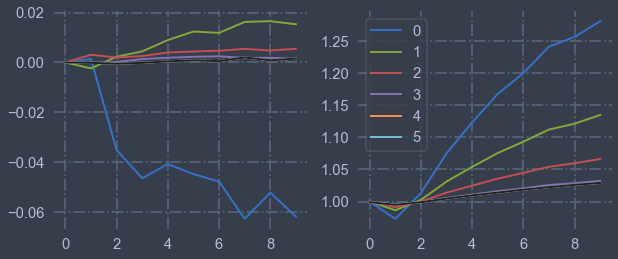

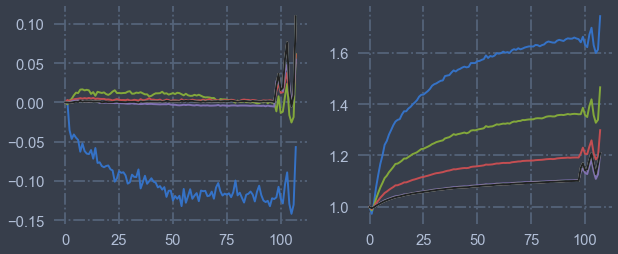

In [15]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [16]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.2810824609375, tensor(0.9113, device='cuda:0')]
valid: [0.1102701416015625, tensor(0.9655, device='cuda:0')]
train: [0.087980361328125, tensor(0.9733, device='cuda:0')]
valid: [0.08470985717773437, tensor(0.9735, device='cuda:0')]
train: [0.06579330078125, tensor(0.9796, device='cuda:0')]
valid: [0.08177369384765625, tensor(0.9754, device='cuda:0')]
Wall time: 12.4 s


In [18]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [19]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [20]:
%time run.fit(3, learn)

train: [0.2225921875, tensor(0.9296, device='cuda:0')]
valid: [0.10869285888671874, tensor(0.9643, device='cuda:0')]
train: [0.0642142236328125, tensor(0.9797, device='cuda:0')]
valid: [0.09623745727539063, tensor(0.9705, device='cuda:0')]
train: [0.0428228466796875, tensor(0.9864, device='cuda:0')]
valid: [0.07834984741210937, tensor(0.9766, device='cuda:0')]
Wall time: 11.3 s


In [21]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.6, 2.), sched_cos(2., 0.1)])

In [22]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [23]:
%time run.fit(8, learn)

train: [0.26589912109375, tensor(0.9181, device='cuda:0')]
valid: [0.15889595947265625, tensor(0.9540, device='cuda:0')]
train: [0.097733994140625, tensor(0.9699, device='cuda:0')]
valid: [0.10849649658203125, tensor(0.9665, device='cuda:0')]
train: [0.05927681640625, tensor(0.9813, device='cuda:0')]
valid: [0.09977636108398437, tensor(0.9724, device='cuda:0')]
train: [0.03673150146484375, tensor(0.9879, device='cuda:0')]
valid: [0.0569861572265625, tensor(0.9831, device='cuda:0')]
train: [0.0221788818359375, tensor(0.9935, device='cuda:0')]
valid: [0.04709396057128906, tensor(0.9861, device='cuda:0')]
train: [0.012235413818359376, tensor(0.9967, device='cuda:0')]
valid: [0.04266823120117187, tensor(0.9882, device='cuda:0')]
train: [0.0070336181640625, tensor(0.9987, device='cuda:0')]
valid: [0.04159360046386719, tensor(0.9890, device='cuda:0')]
train: [0.0052315185546875, tensor(0.9992, device='cuda:0')]
valid: [0.04201309814453125, tensor(0.9888, device='cuda:0')]
Wall time: 29.8 s


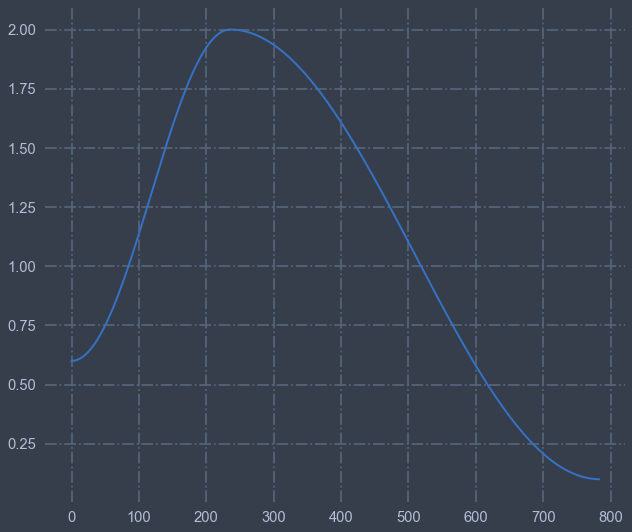

In [24]:
run.recorder.plot_lr()

In [25]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [26]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [28]:
%time run.fit(1, learn)

train: [0.3245966796875, tensor(0.9046, device='cuda:0')]
valid: [0.10475177001953125, tensor(0.9704, device='cuda:0')]
Wall time: 6.26 s


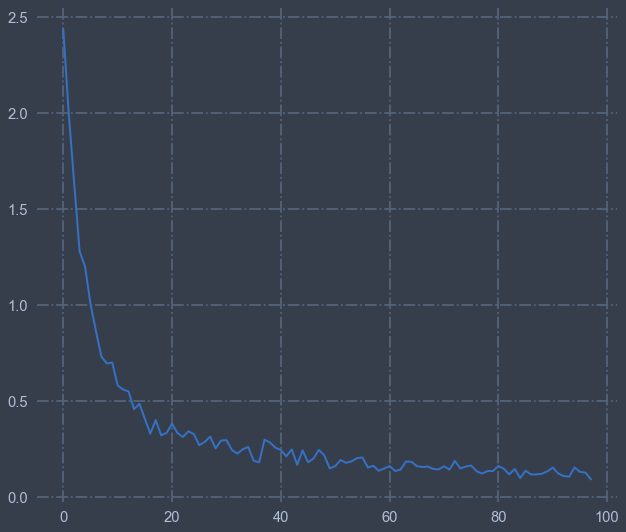

In [29]:
run.recorder.plot_loss()

In [34]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [35]:
learn, run=get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [36]:
%time run.fit(1, learn)

train: [0.18350662109375, tensor(0.9444, device='cuda:0')]
valid: [0.08666058349609375, tensor(0.9827, device='cuda:0')]
Wall time: 47.3 s


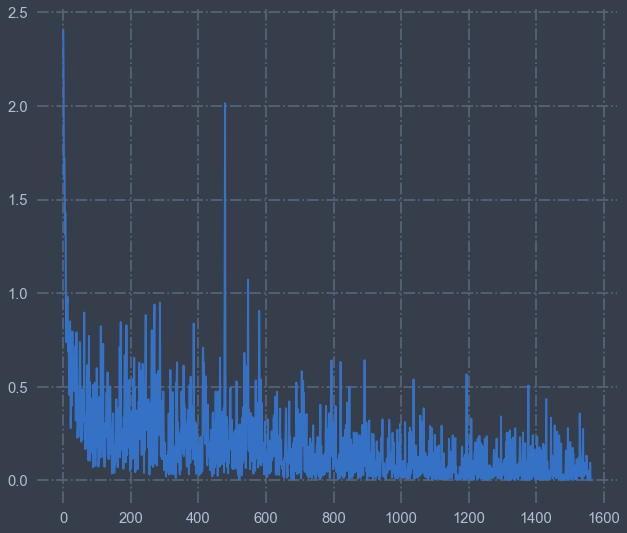

In [37]:
run.recorder.plot_loss()

In [ ]:
nb_auto_export()